In [19]:
#!pip install oolearning --upgrade

In [20]:
import oolearning as oo
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [21]:
csv_file = 'titanic_data.csv'
target_variable = 'Survived'
target_mapping = {0: 'died', 1: 'lived'}  # so we can convert from numeric to categoric

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                target_variable=target_variable,
                                                map_numeric_target=target_mapping)

In [22]:
explore.dataset.head()  # we can access the data directly by `.dataset`

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,died,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,lived,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,lived,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,lived,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,died,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
# Description of data says (https://www.kaggle.com/c/titanic/data):
# pclass: A proxy for socio-economic status (SES)
# 1st = Upper
# 2nd = Middle
# 3rd = Lower

# let's convert Pclass to categoric variable
#explore.set_as_categoric(feature='Pclass', mapping={1: 'Upper', 2: 'Middle', 3: 'Lower'})

In [24]:
explore.numeric_summary()

,count,nulls,perc_nulls,num_zeros,perc_zeros,mean,st_dev,coef of var,skewness,kurtosis,min,10%,25%,50%,75%,90%,max
PassengerId,891,0,0.000,0,0.000,446.000,257.354,0.577,0.000,-1.200,1.00,90.00,223.500,446.000,668.5,802.000,891.000
Pclass,891,0,0.000,0,0.000,2.309,0.836,0.362,-0.631,-1.280,1.00,1.00,2.000,3.000,3.0,3.000,3.000
Age,714,177,0.199,0,0.000,29.699,14.526,0.489,0.389,0.178,0.42,14.00,20.125,28.000,38.0,50.000,80.000
SibSp,891,0,0.000,608,0.682,0.523,1.103,2.108,3.695,17.880,0.00,0.00,0.000,0.000,1.0,1.000,8.000
Parch,891,0,0.000,678,0.761,0.382,0.806,2.112,2.749,9.778,0.00,0.00,0.000,0.000,0.0,2.000,6.000
Fare,891,0,0.000,15,0.017,32.204,49.693,1.543,4.787,33.398,0.00,7.55,7.910,14.454,31.0,77.958,512.329


In [25]:
explore.categoric_summary()

,count,nulls,perc_nulls,top,unique,perc_unique
Name,891,0,0.000,"van Melkebeke, Mr. Philemon",891,1.000
Sex,891,0,0.000,male,2,0.002
Ticket,891,0,0.000,CA. 2343,681,0.764
Cabin,204,687,0.771,B96 B98,147,0.721
Embarked,889,2,0.002,S,3,0.003
Survived,891,0,0.000,died,2,0.002


In [26]:
splitter = oo.ClassificationStratifiedDataSplitter(holdout_ratio=0.20)  # set aside 20% of the data for the holdout set
training_indexes, _ = splitter.split(target_values=explore.dataset.Survived)  # ignore holdout indexes

In [27]:
training_y = explore.dataset.iloc[training_indexes][target_variable]
training_x = explore.dataset.iloc[training_indexes].drop(columns=target_variable)
training_x.shape

(712, 11)

In [28]:
training_x.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,712.000000,712.000000,575.000000,712.000000,712.000000,712.000000
mean,444.405899,2.308989,29.807687,0.492978,0.390449,31.819826
std,257.465527,0.833563,14.485211,1.060720,0.838134,48.059104
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.750000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,439.500000,3.000000,28.500000,0.000000,0.000000,14.454200
75%,667.250000,3.000000,39.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [29]:
len(_)

179

In [30]:
training_y.value_counts(normalize=True)

died     0.616573
lived    0.383427
Name: Survived, dtype: float64

## Evaluate Model Models

In [31]:
global_transformations = [oo.RemoveColumnsTransformer(['PassengerId', 'Name', 'Ticket', 'Cabin']),
                          oo.CategoricConverterTransformer(['Pclass', 'SibSp', 'Parch']),
                          oo.ImputationTransformer(),
                          oo.DummyEncodeTransformer(oo.CategoricalEncoding.ONE_HOT)]

# get the expected columns at the time we do the training, based on the transformations
columns = oo.TransformerPipeline.get_expected_columns(transformations=global_transformations,
                                                      data=explore.dataset.drop(columns=[target_variable]))

# define the models and hyper-parameters that we want to search through
infos = [oo.ModelInfo(description='dummy_stratified',
                      model=oo.DummyClassifier(oo.DummyClassifierStrategy.STRATIFIED),
                      transformations=None,
                      hyper_params=None,
                      hyper_params_grid=None),
         oo.ModelInfo(description='dummy_frequent',
                      model=oo.DummyClassifier(oo.DummyClassifierStrategy.MOST_FREQUENT),
                      transformations=None,
                      hyper_params=None,
                      hyper_params_grid=None),
         oo.ModelInfo(description='Logistic Regression',
                      model=oo.LogisticClassifier(),
                      transformations=[oo.CenterScaleTransformer(), oo.RemoveCorrelationsTransformer()],
                      hyper_params=oo.LogisticClassifierHP(),
                      hyper_params_grid=oo.HyperParamsGrid(
                          params_dict=dict(penalty=['l1', 'l2'],
                                           regularization_inverse=[0.001, 0.01, 0.1, 1, 100, 1000]))),
         oo.ModelInfo(description='Decision Tree',
                      model=oo.CartDecisionTreeClassifier(),
                      transformations=None,
                      hyper_params=oo.CartDecisionTreeHP(),
                      hyper_params_grid=oo.HyperParamsGrid(
                          params_dict=dict(max_depth=[4, 6, 8],
                                           min_samples_leaf=[4, 6, 8],
                                           min_samples_split=[5, 10, 15]))),
         oo.ModelInfo(description='Random Forest',
                      model=oo.RandomForestClassifier(),
                      transformations=None,
                      hyper_params=oo.RandomForestHP(),
                      hyper_params_grid=oo.HyperParamsGrid(
                          params_dict=dict(criterion='gini',
                                           max_features=[int(round(len(columns) ** (1 / 2.0))),
                                                         int(round(len(columns) / 2)),
                                                         len(columns) - 1],
                                           max_depth=None,  # not tuned, default value of sklearn
                                           # min_samples_split=2,
                                           n_estimators=[100, 500, 1000],
                                           min_samples_leaf=[1, 50, 100]))),
         oo.ModelInfo(description='XGBoost',
                      model=oo.XGBoostClassifier(),
                      transformations=None,
                      hyper_params=oo.XGBoostTreeHP(objective=oo.XGBObjective.BINARY_LOGISTIC),
                      hyper_params_grid=oo.HyperParamsGrid(
                          params_dict=dict(colsample_bytree=[0.4, 0.7, 1.0],
                                           subsample=[0.5, 0.75, 1.0],
                                           max_depth=[3, 6, 9])))]

In [32]:
infos[2].hyper_params_grid.params_grid

,penalty,regularization_inverse
0,l1,0.001
1,l1,0.010
2,l1,0.100
3,l1,1.000
4,l1,100.000
5,l1,1000.000
6,l2,0.001
7,l2,0.010
8,l2,0.100
9,l2,1.000


In [33]:
infos[3].hyper_params_grid.params_grid

,max_depth,min_samples_leaf,min_samples_split
0,4,4,5
1,4,4,10
2,4,4,15
3,4,6,5
4,4,6,10
5,4,6,15
6,4,8,5
7,4,8,10
8,4,8,15
9,6,4,5


In [34]:
infos[4].hyper_params_grid.params_grid

,criterion,max_features,max_depth,n_estimators,min_samples_leaf
0,gini,5,None,100,1
1,gini,5,None,100,50
2,gini,5,None,100,100
3,gini,5,None,500,1
4,gini,5,None,500,50
5,gini,5,None,500,100
6,gini,5,None,1000,1
7,gini,5,None,1000,50
8,gini,5,None,1000,100
9,gini,12,None,100,1


In [35]:
infos[5].hyper_params_grid.params_grid

,colsample_bytree,subsample,max_depth
0,0.4,0.50,3
1,0.4,0.50,6
2,0.4,0.50,9
3,0.4,0.75,3
4,0.4,0.75,6
5,0.4,0.75,9
6,0.4,1.00,3
7,0.4,1.00,6
8,0.4,1.00,9
9,0.7,0.50,3


In [36]:
score_list = [oo.AccuracyScore(converter=oo.TwoClassThresholdConverter(threshold=0.5, positive_class='lived')),
              oo.AucRocScore(positive_class='lived'),
              oo.SensitivityScore(converter=oo.TwoClassThresholdConverter(threshold=0.5, positive_class='lived'))]
cache_directory = '/searcher_v1'
searcher = oo.ModelSearcher(global_transformations=global_transformations,
                            model_infos=infos,
                            splitter=oo.ClassificationStratifiedDataSplitter(holdout_ratio=0.25),
                            resampler_function=lambda m, mt: oo.RepeatedCrossValidationResampler(
                                model=m,
                                transformations=mt,
                                scores=score_list,
                                folds=5,
                                repeats=3),
                            persistence_manager=oo.LocalCacheManager(cache_directory=cache_directory))
searcher.search(data=explore.dataset, target_variable='Survived')

/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a fut

/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a fut

/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a fut

/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a fut

/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a fut

/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a fut

/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  correlation_matrix = np.abs(correlation_matrix.as_matrix())
/Users/shanekercheval/anaconda3/lib/python3.6/site-packages/oolearning/transformers/RemoveCorrelationsTransformer.py:41: FutureWarning: Method .as_matrix will be removed in a fut

In [37]:
searcher.results.model_descriptions

['dummy_stratified',
 'dummy_frequent',
 'Logistic Regression',
 'Decision Tree',
 'Random Forest',
 'XGBoost']

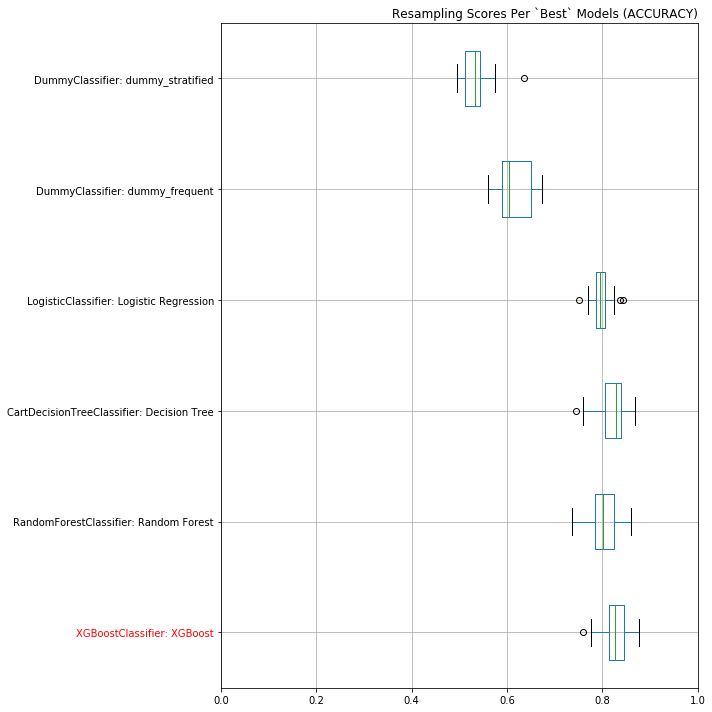

In [38]:
searcher.results.plot_resampled_scores(metric=oo.Metric.ACCURACY)

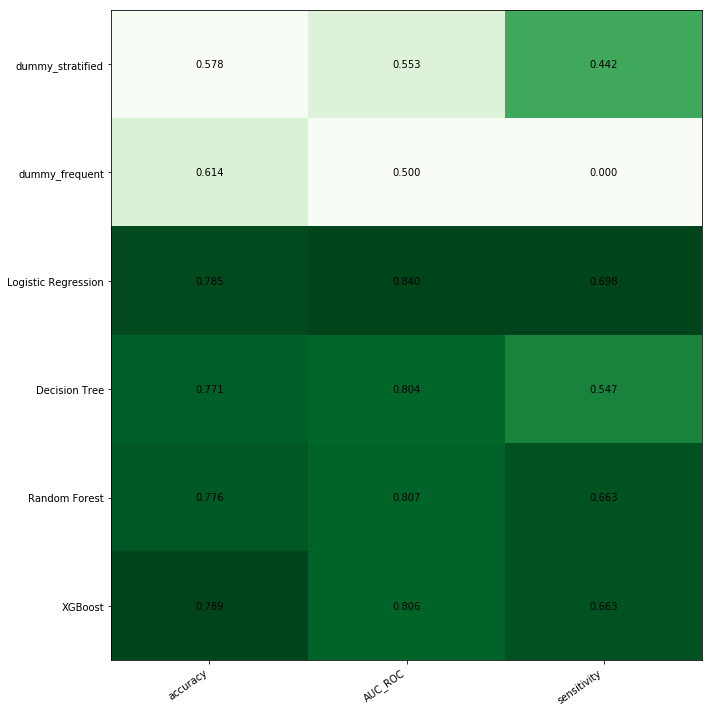

In [39]:
searcher.results.plot_holdout_scores()